
# Red-sequence Modeling
---------------------------------------

Steps:
* Model dependence with stellar mass, fit red-sequence (z-band abs mag)
* Only Red galaxies, wider redshift bin
* One model for each color
* I want only the red-sequence color offset, i.e. residuals

In [21]:
import numpy as np
import os
import esutil

import matplotlib.pyplot as plt
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata
import astropy.io.ascii as at

## Load DES Deep Field

In [3]:
path = '/Users/jesteves/Documents/localProjects/DES/'
fname = path+'y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt20_vl02_catalog_members.fit'
data = Table(getdata(fname))
print('Sample Size: %i'%len(data))
data[:5]

Sample Size: 1169384


MEM_MATCH_ID,Z,RA,DEC,R,P,PFREE,THETA_I,THETA_R,MODEL_MAG,MODEL_MAGERR,REFMAG_FIT,REFMAG_FIT_E,REFMAG,REFMAG_ERR,ZRED,ZRED_E,ZRED2,ZRED2_E,CHISQ,EBV,ZSPEC,ID
int32,float32,float64,float64,float32,float32,float32,float32,float32,float32[4],float32[4],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64
1,0.42608216,43.6189152378926,-59.0218181422348,1.0462141,0.9373733,1.0,1.0,0.99425364,23.061909 .. 20.496489,0.035620525 .. 0.014759269,20.496489,0.014759269,20.496489,0.014759269,0.42593473,0.023969805,0.4249805,0.023278737,0.4963244,0.02139,-1.0,329768078
1,0.42608216,43.6763053491309,-59.0059458065214,1.1013261,0.061688416,1.0,1.0,0.922937,22.983248 .. 20.082335,0.050411567 .. 0.01961935,20.082335,0.01961935,20.082335,0.01961935,0.5035633,0.01579774,0.5010241,0.016083466,14.382589,0.02023,-1.0,329767126
1,0.42608216,43.6177637034504,-59.0179646227669,0.99291486,0.90704405,1.0,1.0,0.99983674,23.012455 .. 20.50317,0.057752177 .. 0.023473794,20.50317,0.023473794,20.50317,0.023473794,0.38649762,0.025751615,0.3865035,0.024986394,1.3523513,0.0214,-1.0,329767864
1,0.42608216,43.6394685284115,-59.0126823611359,1.0008029,0.8889071,1.0,1.0,0.99970436,23.170628 .. 20.700945,0.042157315 .. 0.019664055,20.700945,0.019664055,20.700945,0.019664055,0.39906538,0.026127784,0.39871538,0.025333453,2.2812612,0.02095,-1.0,329767532
1,0.42608216,43.6275254265321,-59.0235219417452,1.0930305,0.25479096,1.0,1.0,0.9441977,22.748894 .. 20.403297,0.05320712 .. 0.029968405,20.403297,0.029968405,20.403297,0.029968405,0.3288632,0.023424914,0.3305776,0.023035632,10.5334215,0.02122,-1.0,329768188


In [18]:
color_label = ['$(g-r)$','$(r-i)$','$(i-z)$']
def plot_color_redshift(data,color_ix,ax=None,**kwargs):
    if ax is None: ax = plt.gca()
    z = data['Z']
    color = data['MODEL_MAG'][:,color_ix]-data['MODEL_MAG'][:,color_ix+1]
    ax.scatter(z,color,**kwargs)
    #ax.set_ylabel(color_label[color_ix])
    ax.set_xlabel('Redshift')

In [19]:
lrgs = (data['ZSPEC']>0) # lrgs sample
red_central = (data['R']<=0.1)&(data['P']>0.3)
red_good    = (data['R']<=1.0)&(data['P']>0.3)

maskLabels = ['lrg','red_central','red_good']
maskList = [lrgs, red_central, red_good]

(0.05, 0.8)

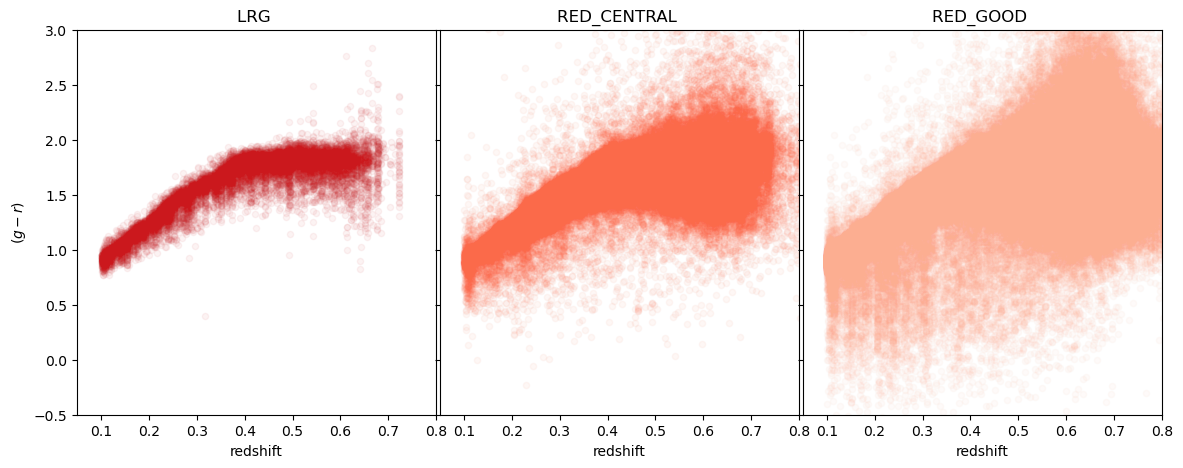

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(14,5), sharex='all', sharey='all')
fig.subplots_adjust(wspace=0.01)
from bokeh.palettes import Reds

colors = Reds[4]
for ix in range(3):
    mask = maskList[ix]
    plot_color_redshift(data[mask], 0, ax=axs[ix], color=colors[ix], alpha=0.05,s=20)
    axs[ix].set_xlabel('redshift')
    axs[ix].set_title('%s '%(maskLabels[ix].upper()))
    axs[ix].set_ylim(-0.5,3.0)
axs[0].set_ylabel(color_label[0])
axs[0].set_xlim(0.05,0.8)
# axs[0].legend(fontsize=16)

# Set Fit Variables

In [48]:
from astropy.cosmology import WMAP9 as cosmo
zvec = np.linspace(0.,1.3,100)
distMod = cosmo.distmod(zvec).value

def get_abs_mag(z,mag):
    DM = np.interp(z,zvec,distMod)
    absMags = mag-DM[:,np.newaxis]
    return absMags

In [73]:
# red and bright
qf = red_central

z = np.array(data['Z'])
mags = np.array(data['MODEL_MAG'])
mags_err = np.array(data['MODEL_MAGERR'])
colors = np.c_[[mags[:,ix]-mags[:,ix+1] for ix in range(3)]].T
colors_err = np.c_[[np.sqrt(mags_err[:,ix]**2+mags_err[:,ix+1]**2) for ix in range(3)]].T

# compute abs mag
abs_mags = get_abs_mag(z,mags)
abs_mag_i = get_abs_mag(z,mags)[:,2]+20

### Make Bins

In [74]:
def make_bins(x,xbins):
    indices = []
    xmd     = 0.5*(xbins[1:]+xbins[:-1])
    for xl,xh in zip(xbins[:-1],xbins[1:]):
        w, = np.where((x<=xh)&(x>xl))
        indices.append(w)
    return indices,xmd

In [75]:
zbins = np.percentile(z, np.linspace(0,100,31))
# zbins[-1] = 1.5
# zbins = np.append(zbins, np.percentile(z[z>zbins[-1]], np.linspace(0,100,3))[1:])

zkeys, zmed = make_bins(z, zbins)
zbins

array([0.1001067 , 0.17068043, 0.22316769, 0.25085464, 0.27947876,
       0.30098721, 0.32384744, 0.35113525, 0.37187323, 0.38944075,
       0.40568388, 0.41955367, 0.43615225, 0.45433408, 0.47088665,
       0.48563081, 0.50149375, 0.51736891, 0.53112531, 0.54490364,
       0.55946171, 0.57432699, 0.58726382, 0.59915106, 0.61085206,
       0.62351692, 0.63718945, 0.65342385, 0.67392415, 0.69981331,
       0.92558092])

In [76]:
# plt.figure(figsize=(4,3))
# _ = plt.hist(z,bins=zbins)
# plt.yscale('log')
# # plt.ylim(90.,)
# plt.ylabel('Number of Red Galaxies')
# plt.xlabel('Redshift')

## Fit Red-Sequence

In [77]:
color_labels = [r'$(%s - %s)$'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]

In [78]:
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
import warnings

def rsFit(x1,y,err):
    g_init = models.Linear1D(1)
    fit = fitting.LevMarLSQFitter()
    or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=3.)

    # Ignore model linearity warning from the fitter
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # Fit
        filtered_data, model = or_fit(g_init, x1, y,weights=1.0/err)
        # filtered_data, model = or_fit(g_init, x1, y)
        mask = np.logical_not(np.ma.getmaskarray(filtered_data))
    return filtered_data.parameters, model

In [79]:
zb = 19

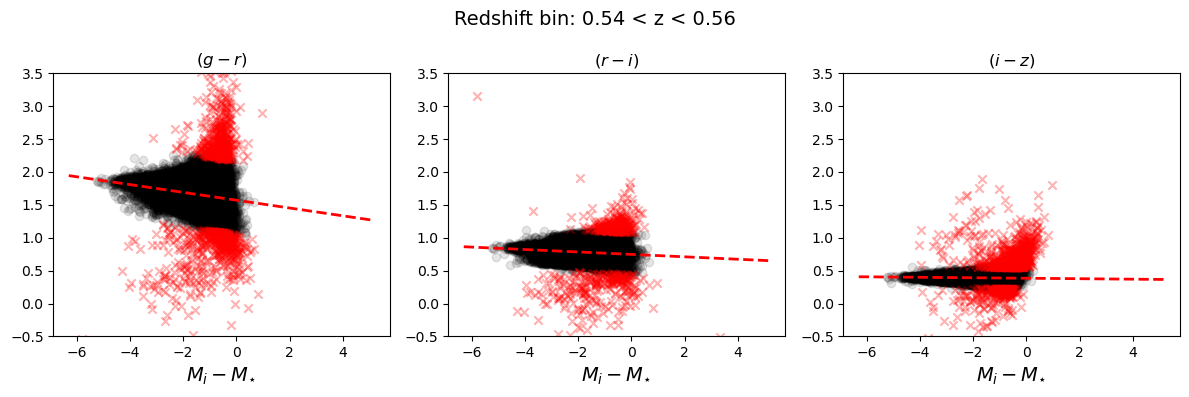

In [82]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

for ix in range(3):
    zcut = (z>=zbins[zb])&(z<=zbins[zb+1])
    coefs, mask = rsFit(abs_mag_i[zcut],colors[zcut,ix],mags_err[zcut,ix])
    
    mibins = np.linspace(np.min(abs_mag_i[zcut])-0.5,np.max(abs_mag_i[zcut])+0.5,21)
    
    axs[ix].plot(mibins, np.poly1d(coefs)(mibins),'r--',lw=2)
    axs[ix].scatter(abs_mag_i[zcut][~mask], colors[zcut,ix][~mask],alpha=0.1,color='k')
    axs[ix].scatter(abs_mag_i[zcut][mask], colors[zcut,ix][mask],alpha=0.3,color='r',marker='x')
    axs[ix].set_title(color_labels[ix],fontsize=12)
    _ = axs[ix].set_xlabel('$M_i-M_{\star}$',fontsize=14)
    axs[ix].set_ylim(-0.5,3.5)
fig.suptitle('Redshift bin: %.2f < z < %.2f'%(zbins[zb],zbins[zb+1]),fontsize=14)
fig.tight_layout()

In [83]:
nbins = len(zkeys)
ncolors = 3
parameters = np.zeros((nbins,ncolors,2))

for i,idx in enumerate(zkeys):
    for j in range(ncolors):
        coefs, mask = rsFit(abs_mag_i[idx],colors[idx,j],mags_err[idx,j])
        parameters[i,j,:] = coefs

In [85]:
## finer binning scheme
zbins2 = np.percentile(z, np.linspace(0,100,101))
zbins2[-1] = 1.5
# zbins = np.append(zbins, np.percentile(z[z>zbins[-1]], np.linspace(0,100,3))[1:])

zkeys2, zmed2 = make_bins(z, zbins2)
zbins2

nbins2 = len(zkeys2)
parameters2 = np.zeros((nbins2,ncolors,2))

for i,idx in enumerate(zkeys2):
    for j in range(ncolors):
        coefs, mask = rsFit(abs_mag_i[idx],colors[idx,j],mags_err[idx,j])
        parameters2[i,j,:] = coefs

In [86]:
final_zmed = np.hstack([zmed,zmed2])
final_parameters = np.vstack([parameters,parameters2])

ixsort = np.argsort(final_zmed)
final_zmed = final_zmed[ixsort]
final_parameters = final_parameters[ixsort]
final_parameters.shape

(130, 3, 2)

In [87]:
from scipy import interpolate
def doInter(xnew, x, y):
    tck = interpolate.splrep(x, y)
    return interpolate.splev(xnew, tck)

In [88]:
from scipy.signal import savgol_filter
final_model = np.zeros_like(final_parameters)

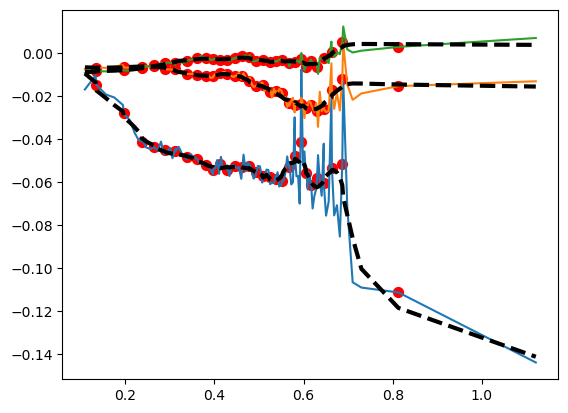

In [90]:
plt.plot(final_zmed,final_parameters[:,:,0])
for i in range(3):
    final_model[:,i,1] = savgol_filter(final_parameters[:,i,1],50,5)
    final_model[:,i,0] = savgol_filter(final_parameters[:,i,0],50,5)
    
    plt.scatter(zmed,parameters[:,i,0],color='r',s=50)
    plt.plot(final_zmed,final_model[:,i,0] ,'k--',lw=3)

In [91]:
print('Saved File: ../data/rs_slope_redMaPPer_y3')
np.savez('../data/rs_slope_redMaPPer_y3', z=final_zmed, coefs=final_model)

Saved File: ../data/rs_slope_redMaPPer_y3


In [92]:
npzfile = np.load('../data/rs_slope_redMaPPer_y3.npz')
npzfile['z'] # zmed

array([0.10945994, 0.1333223 , 0.13539357, 0.15686319, 0.17546105,
       0.19475515, 0.19692406, 0.21068281, 0.22126727, 0.22977038,
       0.23701116, 0.23765606, 0.24613904, 0.25644059, 0.2651667 ,
       0.26597935, 0.27329413, 0.28020325, 0.2872351 , 0.29023299,
       0.29408138, 0.30023439, 0.30591796, 0.31236866, 0.31241733,
       0.31988734, 0.32837693, 0.33723676, 0.33749135, 0.34551774,
       0.35234098, 0.35858804, 0.36150424, 0.36496791, 0.37078993,
       0.37624095, 0.38065699, 0.38148221, 0.3867649 , 0.39196828,
       0.39700437, 0.39756231, 0.40187669, 0.40625578, 0.41054977,
       0.41261877, 0.41465952, 0.41882901, 0.42351021, 0.42785296,
       0.42839153, 0.43354116, 0.43864085, 0.44414161, 0.44524316,
       0.44961227, 0.45491359, 0.46030332, 0.46261036, 0.46535702,
       0.47017001, 0.47471841, 0.47825873, 0.47918446, 0.48351957,
       0.48792256, 0.49273694, 0.49356228, 0.49761836, 0.50238296,
       0.50726825, 0.50943133, 0.51228026, 0.51685044, 0.52093

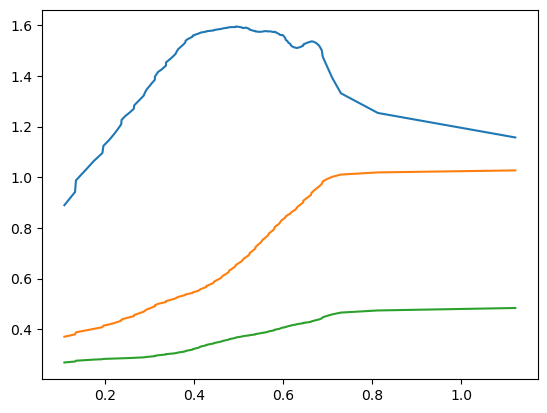

In [93]:
plt.plot(npzfile['z'],npzfile['coefs'][:,:,1]) # mean color at Mi=-20.